# $P(n)$: GP model mixing

## Alexandra Semposki

### Date last edited: 31 January 2024

In [19]:
# import packages
%load_ext autoreload
%autoreload 2

import gsum as gm
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.integrate as scint
import scipy.interpolate as scinterp
from matplotlib.ticker import MultipleLocator, AutoMinorLocator, MaxNLocator
import scipy.stats as stats
import os
import sys
import scipy.optimize as opt
import pandas as pd
from collections import defaultdict
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
import sys
sys.path.append('src/')
sys.path.append('data/')

In [21]:
# import plotting script from J. Melendez
from scripts import *
setup_rc_params()

In [22]:
# import classes for chiral and pQCD
from chiral_model import Chiral_model
from pqcd_reworked import PQCD
from gorda_model import Gorda

# import class to wrap gsum
from truncation_error import Truncation

# import class for speed of sound calculation
from utils import speed_of_sound

### Training data and model evaluations

Here the models are both evaluated at every training and testing point we'll be using, so that we can save this data and pick the proper training points and testing points for the GP later on.

In [23]:
# define density linspace for training and testing
density = np.linspace(0.05, 16.0, 600)

#instantiate pqcd EOS
pqcdk = PQCD(X=2,Nf=2) # X=1 standard for now; Nf=2 for two flavours of quarks

# take the density and invert to obtain the corresponding mu
n_q = density*3.0  # n_q [fm^-3]

# convert to GeV^3 for mu_q units
conversion_fm3 = ((1000.0)**(3.0))/((197.327)**(3.0)) # [fm^-3]  (do the opposite of this)
n0 = 0.16 
n_q = n_q/conversion_fm3

# invert for mu_FG and mu corresponding to chosen n_B
_, mu_n, mu_FG = pqcdk.inversion(n_mu=n_q)

/Users/alexandra/anaconda3/envs/BUQEYE/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:178: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


## Loading GP data

In [40]:
# load training data from GPJaxEmcee calculation for plotting
tr_data = np.load('data/gpjaxemcee_data/correlated_training_data.npz') 
#np.load('data/gpjaxemcee_data/gp_pqcd_training_log.npz')

print(tr_data.files)
print(tr_data['std'])

# load the GP evaluation data from GPJaxEmcee
gp_result = np.load('data/eos_data/sklearn_GP_40.npz')  
#np.load('data/gpjaxemcee_data/gp_pqcd_log.npz')
print(len(gp_result['mean']))

['density', 'dens_log', 'mean', 'std', 'cov']
[0.00714809 0.01492583 0.02604061 0.04085845 0.01254505 0.01022741
 0.00889425 0.00800846]
300


In [41]:
# density settings for evaluation set
density_test = gp_result['density']
#density[::2]

In [42]:
# use the conversion from the pQCD code to see if this resolves things
convert_pqcd = np.load('data/eos_data/pqcd_fg_data.npz')

# interpolate for a functional form to use 
convert_interp = scinterp.interp1d(convert_pqcd['density'], convert_pqcd['mean'], \
                                 kind='cubic', fill_value='extrapolate')
pqcd_convert_arr = convert_interp(density_test)

## Speed of sound calculation, $c_{s}^{2}(n)$ <a id="cs2_taweret"></a>

We need to extract the speed of sound from the pressure equation. The most direct way to do this is to integrate the $P(n)$ curve to get the energy density. 

$$
P(n) = n^{2} \frac{\partial (\varepsilon/n)}{\partial n}
$$

$$
\varepsilon(n) = n \left[\int_{min(n)}^{n} \frac{P(n)}{n^{2}} dn + \frac{\varepsilon(min(n))}{min(n)} \right],
$$

where $min(n)$ is 0.05 fm$^{-3}$, and $max(n)$ is 16.0 fm$^{-3}$.

After we achieve the energy density in this manner, we will then code the chemical potential as

$$
\mu = \frac{P(n) + \varepsilon(n)}{n},
$$

and finally obtain the speed of sound, given as

$$
c_{s}^{2}(n) = \frac{\partial P}{\partial n } / \frac{\partial \varepsilon}{\partial n} = \frac{1}{\mu} \frac{\partial P(n)}{\partial n}.
$$

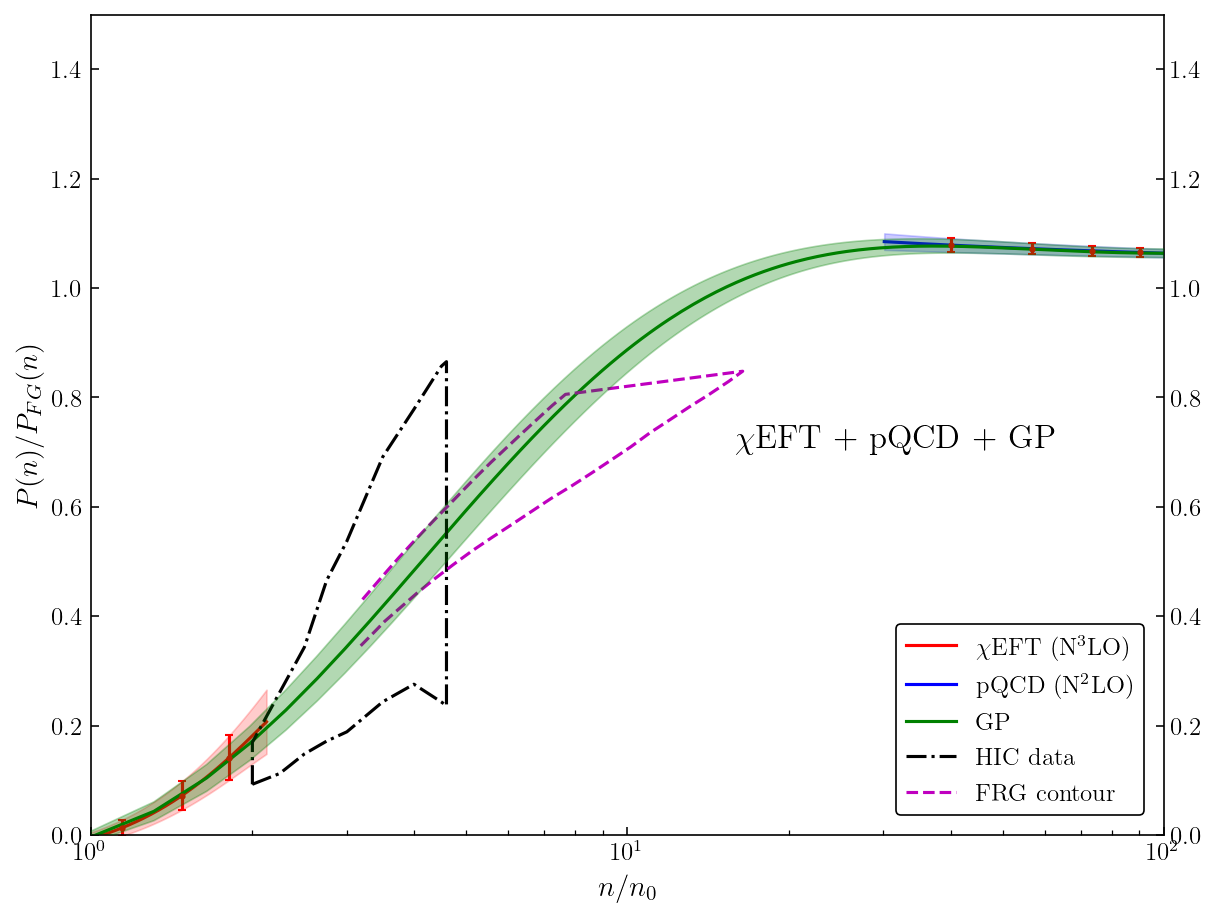

-0.07087531573535541


In [43]:
# import the data from the ChEFT, pQCD files directly as the models
chiral_result = np.load('data/eos_data/pressure_chiral_data_scaled_2n0.npz')
pqcd_result = np.load('data/eos_data/pressure_pqcd_data_scaled.npz')

# plot BMM result
fig = plt.figure(figsize=(8,6), dpi=150)
ax = plt.axes()
ax.set_xlim(1.0, max(density/n0))
ax.set_ylim(0.0,1.5)
ax.tick_params(axis='both', which='major', labelsize=12, labelright=True, right=True)
ax.tick_params(axis='both', which='minor', labelsize=10, labelright=True)
ax.text(0.9,0.5, r'$\chi$EFT + pQCD + GP', ha='right', va='top',
        transform=ax.transAxes, fontsize=16)
ax.set_xlabel(r'$n/n_{0}$', fontsize=14)
ax.set_ylabel(r'$P(n)/P_{FG}(n)$', fontsize=14)

colors = ['r', 'b', 'g']
labels = [r'$\chi$EFT (N$^{3}$LO)', r'pQCD (N$^{2}$LO)', 'Mixed model']

# assign means and std devs for easier use
mean_chiral = chiral_result['mean'][:,3]
mean_pqcd = pqcd_result['mean'][:,2]
std_dev_chiral = chiral_result['std_dev'][:,3]
std_dev_pqcd = pqcd_result['std_dev'][:,2]

# stop plotting past this point
ind_cut = np.where(pqcd_result['dens_scaled'] >= 30.0)[0][0]

# model means
ax.plot(chiral_result['density']/n0, chiral_result['mean'][:,3], color=colors[0], label=labels[0])
ax.plot(pqcd_result['density'][ind_cut:]/n0, pqcd_result['mean'][ind_cut:,2], color=colors[1], label=labels[1])

# PPD mean (testing data array)
ax.plot(gp_result['density']/n0, gp_result['mean'], color='g', label='GP')

# model uncertainties
ax.fill_between(chiral_result['density']/n0, mean_chiral - 1.0*std_dev_chiral, mean_chiral + 1.0*std_dev_chiral, color=colors[0], alpha=0.2)
ax.fill_between(pqcd_result['density'][ind_cut:]/n0, mean_pqcd[ind_cut:] - 1.0*std_dev_pqcd[ind_cut:], mean_pqcd[ind_cut:] + 1.0*std_dev_pqcd[ind_cut:], \
                color=colors[1], alpha=0.2)

# PPD band (testing data array)
ax.fill_between(gp_result['density']/n0, gp_result['mean']-1.0*gp_result['std'], gp_result['mean']+1.0*gp_result['std'],
                       zorder=5, facecolor='g', edgecolor='g', alpha=0.3)

# import contours and plot
df = pd.read_csv('data/contour_scaled.csv')
df_frg = pd.read_csv('data/frg_data_pressure.csv')
df_hhic = pd.read_csv('data/hic_data_huth.csv')
df_hfrg = pd.read_csv('data/frg_data_huth.csv')

# frg unscaling
pressure_free = np.zeros([len(df_frg['n/n0'])])
p_fg = np.zeros([len(density_test)])
hbarc = 197.327 # MeV fm

# contour kf_s calculated here
contour_kf_s_fg = fermi_momentum(density=density_test, degeneracy=4)
contour_kf_s = fermi_momentum(density=0.16*df_frg['n/n0'], degeneracy=4)

for i in range(len(df_frg['n/n0'])):
    pressure_free[i] = ((1.0/(2.0*np.square(np.pi)))*(contour_kf_s[i]**4.0))*(hbarc)
p_fg = pqcd_convert_arr
    
# unscale FRG
frg_unscaled = df_frg['P/P_free']*pressure_free
ax.plot(df['Density/n0'], df['p_pfg'], color='k', linestyle='dashdot', label='HIC data')
ax.plot(df_frg['n/n0'], df_frg['P/P_free'], color='m', linestyle='dashed', label='FRG contour')

# plot the training points
plt.errorbar(tr_data["density"]/n0, tr_data["mean"], yerr=tr_data["std"], \
             color='red', fmt='o', markersize=2, capsize=2)

# legend
ax.set_xscale('log')
ax.legend(loc='lower right', fontsize=12)
plt.show()

print(mean_chiral[0] - gp_result['mean'][0])

interp_gp = scinterp.interp1d(gp_result['density'], gp_result['mean'], kind='cubic', fill_value='extrapolate')
#print((interp_gp(chiral_result['density']) - mean_chiral)/mean_chiral)

In [44]:
# calculating the errors around 'breakdown'
from scipy.interpolate import interp1d
from scipy.optimize import fsolve

# interpolate to obtain bands at exactly 2*n0
chiral_interp = interp1d(chiral_result['density'], mean_chiral, kind='cubic', fill_value='extrapolate')
chiral_low_interp = interp1d(chiral_result['density'], mean_chiral-1.0*std_dev_chiral, \
                             kind='cubic', fill_value='extrapolate')
chiral_hi_interp = interp1d(chiral_result['density'], mean_chiral+1.0*std_dev_chiral, \
                           kind='cubic', fill_value='extrapolate')

# evaluate exactly at 2*n0
chi_mean_2 = chiral_interp(2.0*n0)
chi_low_2 = chiral_low_interp(2.0*n0)
chi_hi_2 = chiral_hi_interp(2.0*n0)

# store results and print
chiral_cutoff = {
    'mean': chi_mean_2,
    'lower': chi_mean_2 - chi_low_2,
    'upper': chi_hi_2 - chi_mean_2
}

print('At 2.0*n0, chiral EFT yields the values: ', chiral_cutoff)

# print relative error there
rel_err = chiral_cutoff['upper']/chiral_cutoff['mean']
print('Relative error: ', rel_err, 'and % error: ', rel_err*100.)

# now do the same for pQCD --- find the location in density for the same 68% interval
#print(std_dev_pqcd/mean_pqcd)
pqcd_rel_interp = interp1d(pqcd_result['density'][120:], std_dev_pqcd[120:]/mean_pqcd[120:], kind='cubic', fill_value='extrapolate')
pqcd_rel_dens = fsolve(lambda n : rel_err - pqcd_rel_interp(n), x0 = 3.0, xtol=1e-08)[0]
print('pQCD density location for equal relative error: ', pqcd_rel_dens, '[fm^-3]')
print('pQCD density in terms of n0: ', pqcd_rel_dens/n0)
print('Relative error at this exact point: ', pqcd_rel_interp(pqcd_rel_dens))
print(pqcd_rel_interp(pqcd_rel_dens))
print(rel_err - pqcd_rel_interp(pqcd_rel_dens))

# check by eye where the same relative error happens # alpha_s case, 1.5, 2.0
# print(std_dev_pqcd[22]/mean_pqcd[22])
# pqcd_result['density'][22]  # excellent!!!

# check by eye where the same relative error happens # Nf*alpha_s/pi case, 1.5, 2.0
# print(std_dev_pqcd[17]/mean_pqcd[17])
# print(pqcd_result['density'][17]/n0)
# print(std_dev_pqcd[13]/mean_pqcd[13])
# pqcd_result['density'][13]/n0  # excellent!!!
print(std_dev_pqcd[120]/mean_pqcd[120])

At 2.0*n0, chiral EFT yields the values:  {'mean': array(0.18173804), 'lower': 0.05111139434934983, 'upper': 0.05111139434934983}
Relative error:  0.28123663190575987 and % error:  28.123663190575986
pQCD density location for equal relative error:  -3.943747409980865 [fm^-3]
pQCD density in terms of n0:  -24.648421312380407
Relative error at this exact point:  0.28123663190308434
0.28123663190308434
2.6755264670441647e-12
0.018305244273397647


__Note__: At this point, the expansion parameter is only alpha_s, and this value in pQCD is: 3.9840357192597797 * n0. 

For an expansion parameter of Nf * alpha_s/pi, we get: 2.5368747983965827 * n0. 

## Speed of sound calculation, $c_{s}^{2}(n)$ <a id="cs2_gp"></a>

This thing could be checked on chiral EFT as well, by running it to see if the speed of sound mean curve is approximately recovered. If not, then we know something is up there.

In [34]:
# try checking against chiral EFT
mean_chi = chiral_result['mean'][:,3]
std_chi = chiral_result['std_dev'][:,3]

# only use from saturation up, so cut the arrays
sat_cut = (np.where([i >= 0.16 for i in chiral_result['density']])[0][0])

pres_dict = {
    'mean': (mean_chi*convert_interp(chiral_result['density']))[sat_cut:],
    'std_dev': (std_chi*convert_interp(chiral_result['density']))[sat_cut:]
}

# anchor point at 0.05 fm^-3
en_0 = 46.527
en_0_lower = en_0 - 0.0307
en_0_upper = en_0 + 0.0307

# anchor point at 0.16 fm^-3
en_0 = 147.97129
en_0_lower = 147.83521
en_0_upper = 148.1073

edens_dict = {
    'mean':en_0,
    'lower':en_0_lower,
    'upper':en_0_upper
}

# calculate the speed of sound and compare to the saved data
dens_arr, _, _, cs2_old, edens_int, _ = speed_of_sound(chiral_result['density'][sat_cut:], pres_dict, edens_dict, sat=False)

plt.plot(dens_arr/n0, cs2_old['mean'])
plt.plot(poster_cs2_chi['density']/n0, poster_cs2_chi['mean'][:,3])

print('Value of the integral at last point: ', edens_int['mean'][-1])

ValueError: not enough values to unpack (expected 6, got 5)

(899,)


ValueError: x and y must have same first dimension, but have shapes (300,) and (899, 500)

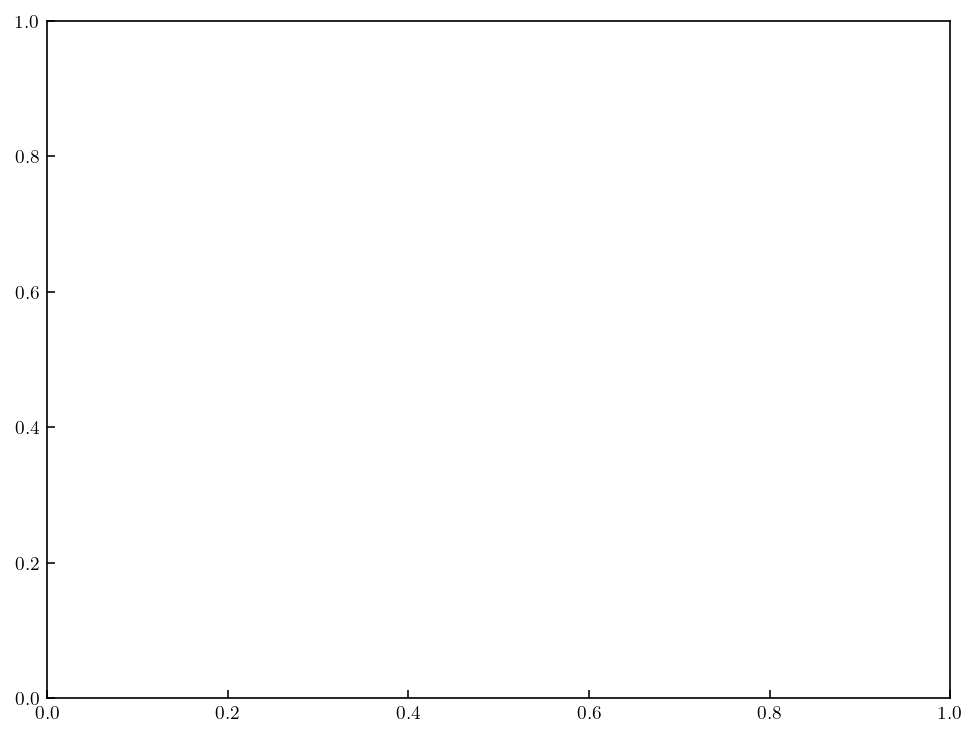

In [18]:
# unscale the variables using what we've got for now and store in a dict
samples_data = np.load('data/gpjaxemcee_data/gp_pqcd_with_samples.npz')
pres_samples = samples_data['samples']

# run interpolation for FG scaling
gp_cs2_convert_arr = convert_interp(samples_data['density'])
print(gp_cs2_convert_arr.shape)

# unscale the samples from the FG scaling
pres_samples_unscaled = [pres_samples[:,i]*gp_cs2_convert_arr \
                         for i in range(len(np.asarray(pres_samples).T))]

# test result
plt.plot(gp_result['density']/n0, np.asarray(pres_samples_unscaled).T)
plt.show()

# cut at saturation (or thereabouts)
dens_gp = np.asarray(gp_result['density'])
sat_cut = (np.where([i >= 0.16 for i in dens_gp])[0][0]) - 1

print(dens_gp[sat_cut])

# pull dict values out and make arrays
gp_mean = np.asarray(gp_result['mean'])
gp_std = np.asarray(gp_result['std'])

# send to the speed of sound calculation (for interpolation)
pres_dict = {
    'mean': gp_mean[sat_cut:]*gp_cs2_convert_arr[sat_cut:],
    'std_dev': gp_std[sat_cut:]*gp_cs2_convert_arr[sat_cut:],
    'samples': np.asarray(pres_samples_unscaled)[:, sat_cut:].T
}

# interpolate the energy density for the correct values
edens_data = np.load('data/eos_data/edens_data_chiral.npz')
edens_interp = scinterp.interp1d(edens_data['density'], \
                                 edens_data['mean'], kind='cubic', fill_value='extrapolate')
edens_interp_std = scinterp.interp1d(edens_data['density'], \
                                     edens_data['std'], kind='cubic', fill_value='extrapolate')
# en_0 = edens_interp(dens_gp[sat_cut])
# en_0_lower = en_0 - edens_interp_std(dens_gp[sat_cut])
# en_0_upper = en_0 + edens_interp_std(dens_gp[sat_cut])

# integrating backwards (mean for now only)
en_0 = 47637.52750259489        #edens_interp(density[1])  # BC at 100*n0
en_0_lower = 47505.507238020364 #en_0 - edens_interp_std(density[1])
en_0_upper = 47769.54772653198

# # 0.16 values for this calculation (now 0.1565)
# en_0 = 144.7495   #120.20359      #46.52745253 #95.68805504 #144.74947715      #147.97129279447282            #46.52745253488445 
# en_0_lower = en_0 - 0.126218 #- 0.066886       #46.525 #en_0 - 0.03070869  #147.8352141571533       #46.525
# en_0_upper = en_0 + 0.126218 #+ 0.066886       #46.530 #en_0 + 0.03070869 #148.10737143179233      #46.530

edens_dict = {
    'mean': en_0,  # 175 for n0 gives me something good for pQCD
    'lower': en_0_lower,
    'upper': en_0_upper
}

# call speed of sound function
cs2_log, edens_full = speed_of_sound(dens_gp[sat_cut:], pres_dict, edens_dict, sat=False, sampled=True)
dens_arr, _, _, cs2_old, edens_int, _ = speed_of_sound(dens_gp[sat_cut:], pres_dict, \
                                                       edens_dict, sat=False, integrate='backward')

# dict entries
cs2_log_mean = cs2_log['mean']
cs2_log_std = cs2_log['std']
cs2_log_samples = cs2_log['samples']

# edens plot
edens_npz = np.load('edens_comparison.npz')
#[plt.plot(dens_gp[sat_cut:]/n0, edens_full[i]) for i in range(len(edens_full))]
plt.plot(edens_npz['density']/n0, np.asarray(edens_npz['mean']), 'k', zorder=10)
plt.plot(dens_arr/n0, np.asarray(edens_int['mean']), color='black', \
         linestyle='dashed')  # does it REALLY shrink this much?
# plt.xlim(0.0, 20.0)
# plt.ylim(0.0, 1000.0)
plt.xscale('log')

# print number at edge
print('At 100*n0, the value of the energy density is: ', np.asarray(edens_int['mean'])[-1])
print('At 100*n0, the value of the energy density is: ', np.asarray(edens_npz['mean'])[-1])

plt.show()

# samples plot
[plt.plot(dens_gp[sat_cut:]/n0, cs2_log_samples[i]) for i in range(len(edens_full))]
plt.axhline(y=1.0/3.0, linestyle='dashed')
plt.xlabel(r'$n/n_{0}$')
plt.ylabel(r'$c_{s}^{2}(n)$')
plt.xlim(0.16/n0, 16.0/n0)
plt.xscale('log')
plt.ylim(0.0, 0.75)
plt.show()

# mean and std dev band plot
[plt.plot(dens_gp[sat_cut:]/n0, cs2_log_samples[i], alpha=0.1) for i in range(len(edens_full))]
plt.plot(dens_gp[sat_cut:]/n0, cs2_log_mean, 'k', zorder=20)
plt.fill_between(dens_gp[sat_cut:]/n0, \
                 cs2_log_mean-cs2_log_std, cs2_log_mean+cs2_log_std, zorder=12)
plt.fill_between(dens_gp[sat_cut:]/n0, \
                 cs2_log_mean-1.96*cs2_log_std, cs2_log_mean+1.96*cs2_log_std, zorder=10)
plt.axhline(y=1.0/3.0, linestyle='dashed')
plt.xlabel(r'$n/n_{0}$')
plt.ylabel(r'$c_{s}^{2}(n)$')
plt.xlim(0.13/n0, 16.0/n0)
plt.xscale('log')
plt.ylim(0.0, 0.75)
plt.show()

# plot integrands
plt.plot(dens_gp[sat_cut:], pres_dict['mean']/(dens_gp[sat_cut:]**2.0))
plt.plot(pqcd_result['density'], \
         mean_pqcd*convert_interp(pqcd_result['density'])/(pqcd_result['density']**2.0))
plt.plot(chiral_result['density'], \
         mean_chiral*convert_interp(chiral_result['density'])/(chiral_result['density']**2.0))
plt.axhline(y=0.0)
plt.ylim(-100., 500.)
plt.show()

# plot the result from integrating backwards with the GP
plt.axhline(y=0.333333, color='grey', linestyle='dashed')  # conformal limit
plt.fill_between(poster_cs2_chi['density']/n0, poster_cs2_chi['mean'][:,3]+poster_cs2_chi['std'][:,3], \
                 poster_cs2_chi['mean'][:,3]-poster_cs2_chi['std'][:,3], alpha=0.7, zorder=0, \
                   facecolor=light_colors[0], edgecolor=colors[0])
plt.plot(poster_cs2_chi['density']/n0, poster_cs2_chi['mean'][:,3], color=colors[0], zorder=1, linewidth=2, \
           label=r'$\chi$EFT (N$^3$LO)')
plt.plot(poster_cs2_pqcd['density']/n0, poster_cs2_pqcd['mean'], color=colors[1], zorder=3, linewidth=2, \
         label=r'pQCD (N$^2$LO)')
plt.fill_between(poster_cs2_pqcd['density']/n0, poster_cs2_pqcd['lower'], poster_cs2_pqcd['upper'], \
                 zorder=2, facecolor=light_colors[1], edgecolor=colors[1], alpha=0.7)
plt.plot(dens_gp[sat_cut:]/n0, cs2_log_mean, 'k', zorder=20)
plt.fill_between(dens_gp[sat_cut:]/n0, \
                 cs2_log_mean-cs2_log_std, cs2_log_mean+cs2_log_std, zorder=12, alpha=0.3)
plt.xlim(0.05/n0, 16.0/n0)
plt.xscale('log')
plt.ylim(0.0, 0.75)
plt.show()

OK, checked the error bands, and they're just really really small at the points above 10n0.

In [19]:
# print out bands
#print(cs2_old['lower']-cs2_old['upper'])

###### What is going on at the low end? Not able to anchor because of np.gradient and not enough points, or ...? Can generate more points using the GP.

## Creating the poster plot

Now we need to use both the $P(n)$ result and the $c_{s}^{2}(n)$ result in one set of subplots so that we can present them side-by-side in the poster for the INPP Open House. We can simply call the data files and load them into the plot here, if we wish to avoid any running of the main code above, since we are only using the GP result for the poster and not the totally mixed result.

In [20]:
# load the data for both plots
poster_chi = np.load('data/eos_data/pressure_chiral_data_scaled_2n0.npz')
poster_pqcd = np.load('data/eos_data/pressure_pqcd_data_scaled.npz')
poster_gp = gp_result
poster_cs2_chi = np.load('data/eos_data/speedofsoundchiral.npz')
poster_cs2_pqcd = np.load('data/eos_data/pqcd_cs2_11.2.npz')

# contour plot data
df = pd.read_csv('data/contour_scaled.csv')
df_frg = pd.read_csv('data/frg_data_pressure.csv')
df_hhic = pd.read_csv('data/hic_data_huth.csv')
df_hfrg = pd.read_csv('data/frg_data_huth.csv')

In [21]:
# set up other variables
n0 = 0.16 # fm^-3

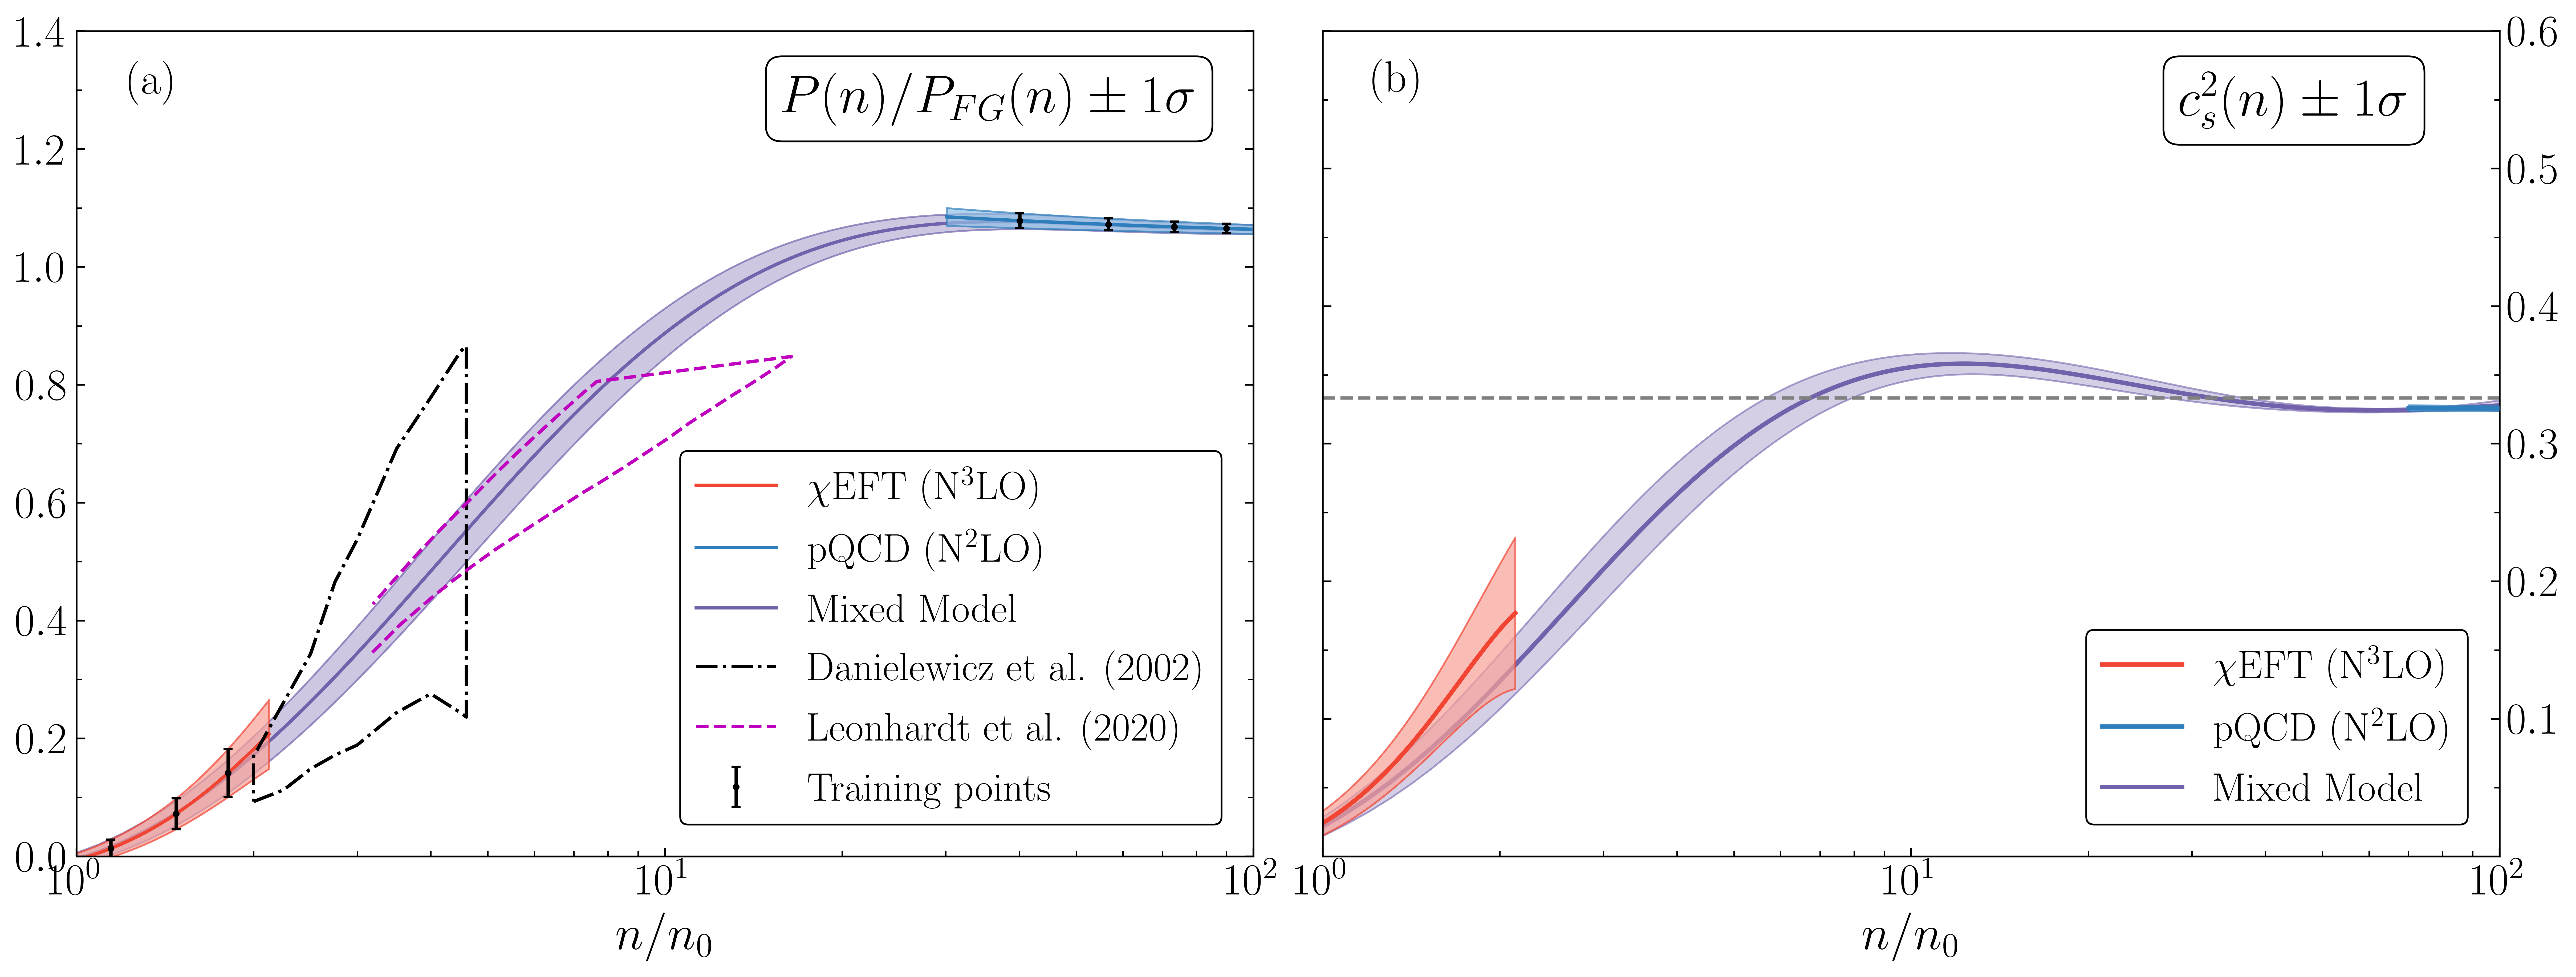

In [24]:
# set up the plot requirements
fig, ax = plt.subplots(1, 2, figsize=(16,6), dpi=600, sharex='col')
#fig.patch.set_alpha(0.0)
ax[0].set_xlim(1.00, max(density/n0))
ax[0].set_ylim(0.0,1.4)
ax[0].tick_params(axis='both', which='major', labelsize=20, right=True)
ax[0].tick_params(axis='both', which='minor', labelsize=20, right=True)
ax[0].xaxis.set_major_locator(MultipleLocator(10))
ax[0].yaxis.set_minor_locator(MultipleLocator(0.1))
ax[0].text(
    80.0,1.33, r'$P(n)/P_{FG}(n) \pm 1\sigma$', ha='right', va='top',
    multialignment='center', zorder=10, fontsize=24,
    bbox=dict(facecolor='w', boxstyle='round')
)
ax[0].text(1.5, 1.35, r'(a)', ha='right', va='top', fontsize=20)
ax[0].set_xlabel(r'$n/n_{0}$', fontsize=22)
ax[0].set_xscale('log')

ax[1].set_xlim(1., max(density/n0))
ax[1].set_ylim(1e-6,0.6)
ax[1].xaxis.set_major_locator(MultipleLocator(10))
ax[1].yaxis.set_minor_locator(MultipleLocator(0.05))
ax[1].tick_params(axis='both', which='major', labelsize=20, labelleft=False, labelright=True, right=True)
ax[1].tick_params(axis='both', which='minor', labelsize=20, labelleft=False, labelright=True, right=True)
ax[1].text(
    70.0,0.57, r'$c_{s}^{2}(n) \pm 1\sigma$', ha='right', va='top',
    multialignment='center', zorder=10, fontsize=24,
    bbox=dict(facecolor='w', boxstyle='round')
)
ax[1].text(1.5, 0.58, r'(b)', ha='right', va='top', fontsize=20)
ax[1].set_xlabel(r'$n/n_{0}$', fontsize=22)
ax[1].set_xscale('log')

orders = [0,1,2]

# plotting assistance
order_labels = [r'$\chi$EFT (N$^{3}$LO)', r'pQCD (N$^{2}$LO)', 'Mixed Model']
color_list = ['Reds', 'Blues','Purples', 'Oranges', 'Greens', 'Greys']
cmaps = [plt.get_cmap(name) for name in color_list[:len(orders)]]
colors = [cmap(0.7 - 0.1 * (i == 0)) for i, cmap in enumerate(cmaps)]
light_colors = [lighten_color(color, 0.5) for color in colors]
dark_colors = [lighten_color(color, 1.5) for color in colors]

# assign means and std devs for easier use
mean_chiral = poster_chi['mean'][:,3]
mean_pqcd = poster_pqcd['mean'][:,2]
std_dev_chiral = poster_chi['std_dev'][:,3]
std_dev_pqcd = poster_pqcd['std_dev'][:,2]

# pressure data

# model means and uncertainties
ax[0].fill_between(poster_chi['density']/n0, mean_chiral - 1.0*std_dev_chiral, mean_chiral + 1.0*std_dev_chiral, \
                   facecolor=light_colors[0], edgecolor=colors[0], zorder=0, alpha=0.7)

ax[0].plot(poster_chi['density']/n0, poster_chi['mean'][:,3], color=colors[0], zorder=1, label=labels[0])

ax[0].fill_between(poster_pqcd['density'][ind_cut:]/n0, mean_pqcd[ind_cut:] - 1.0*std_dev_pqcd[ind_cut:], mean_pqcd[ind_cut:] + 1.0*std_dev_pqcd[ind_cut:], \
                facecolor=light_colors[1], edgecolor=colors[1], zorder=2, alpha=0.7)

ax[0].plot(poster_pqcd['density'][ind_cut:]/n0, poster_pqcd['mean'][ind_cut:,2], zorder=3, color=colors[1], label=labels[1])

# PPD band (testing data array)
ax[0].fill_between(poster_gp['density']/n0, poster_gp['mean']-1.0*poster_gp['std'], poster_gp['mean']+ \
                   1.0*poster_gp['std'],
                       zorder=-2, facecolor=light_colors[2], edgecolor=colors[2], alpha=0.7)

# PPD mean (testing data array)
ax[0].plot(poster_gp['density']/n0, poster_gp['mean'], color=colors[2], zorder=-1, label='Mixed Model')

# frg unscaling
pressure_free = np.zeros([len(df_frg['n/n0'])])
p_fg = np.zeros([len(density_test)])
hbarc = 197.327 # MeV fm

# contour kf_s calculated here
contour_kf_s_fg = fermi_momentum(density=density_test, degeneracy=4)
contour_kf_s = fermi_momentum(density=0.16*df_frg['n/n0'], degeneracy=4)

for i in range(len(df_frg['n/n0'])):
    pressure_free[i] = ((1.0/(2.0*np.square(np.pi)))*(contour_kf_s[i]**4.0))*(hbarc)
p_fg = pqcd_convert_arr
    
# unscale FRG
frg_unscaled = df_frg['P/P_free']*pressure_free
ax[0].plot(df['Density/n0'], df['p_pfg'], color='black', linestyle='dashdot', zorder=10, label='Danielewicz et al. (2002)')
ax[0].plot(df_frg['n/n0'], df_frg['P/P_free'], color='m', linestyle='dashed', zorder=10, label='Leonhardt et al. (2020)')

# plot the training points
ax[0].errorbar(tr_data["density"]/n0, tr_data["mean"], yerr=tr_data["std"], \
             color='black', fmt='o', zorder= 11, markersize=2, capsize=2, label=r'Training points')

# legend
ax[0].legend(loc='lower right', facecolor='w', fontsize=18)

# speed of sound data 
ax[1].axhline(y=0.333333, color='grey', linestyle='dashed')  # conformal limit

# plot the result from chiral to see differences
ax[1].fill_between(poster_cs2_chi['density']/n0, poster_cs2_chi['mean'][:,3]+poster_cs2_chi['std'][:,3], \
                 poster_cs2_chi['mean'][:,3]-poster_cs2_chi['std'][:,3], alpha=0.7, zorder=0, \
                   facecolor=light_colors[0], edgecolor=colors[0])
ax[1].plot(poster_cs2_chi['density']/n0, poster_cs2_chi['mean'][:,3], color=colors[0], zorder=1, linewidth=2, \
           label=r'$\chi$EFT (N$^3$LO)')

# plot the result from pqcd to see differences
plt.plot(poster_cs2_pqcd['density']/n0, poster_cs2_pqcd['mean'], color=colors[1], zorder=3, linewidth=2, label=r'pQCD (N$^2$LO)')
plt.fill_between(poster_cs2_pqcd['density']/n0, poster_cs2_pqcd['lower'], poster_cs2_pqcd['upper'], zorder=2, facecolor=light_colors[1], edgecolor=colors[1], alpha=0.7)

# GP data
ax[1].fill_between(dens_gp[sat_cut:]/n0, cs2_log_mean-cs2_log_std, cs2_log_mean+cs2_log_std, zorder=-2, facecolor=light_colors[2], edgecolor=colors[2], alpha=0.6)
ax[1].plot(dens_gp[sat_cut:]/n0, cs2_log['mean'], color=colors[2], linewidth=2, zorder=-1, label=r'Mixed Model')

ax[1].legend(loc='lower right', facecolor='w', fontsize=18)
plt.show()
fig.savefig('subplot_curvewise_model_Nfalphaspi.PNG', bbox_inches='tight')